Found 8905 images belonging to 6 classes.
Found 1068 images belonging to 6 classes.
Found 765 images belonging to 6 classes.


Epoch 1/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 3326s 12s/step - accuracy: 0.9417 - loss: 0.2017 - val_accuracy: 0.9307 - val_loss: 0.2359 - learning_rate: 1.0000e-05
Epoch 2/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 3259s 12s/step - accuracy: 0.9478 - loss: 0.1696 - val_accuracy: 0.9335 - val_loss: 0.2238 - learning_rate: 1.0000e-05
Epoch 3/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 3201s 11s/step - accuracy: 0.9501 - loss: 0.1671 - val_accuracy: 0.9316 - val_loss: 0.2242 - learning_rate: 1.0000e-05
Epoch 4/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 3184s 11s/step - accuracy: 0.9482 - loss: 0.1626 - val_accuracy: 0.9354 - val_loss: 0.2168 - learning_rate: 1.0000e-05
Epoch 5/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 3200s 11s/step - accuracy: 0.9491 - loss: 0.1554 - val_accuracy: 0.9345 - val_loss: 0.2134 - learning_rate: 1.0000e-05
Epoch 6/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 3171s 11s/step - accuracy: 0.9466 - loss: 0.1586 - val_accuracy: 0.9335 - val_loss: 0.2131 - learning_rate: 1.0000e-05
Epoch 7/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 3201s 

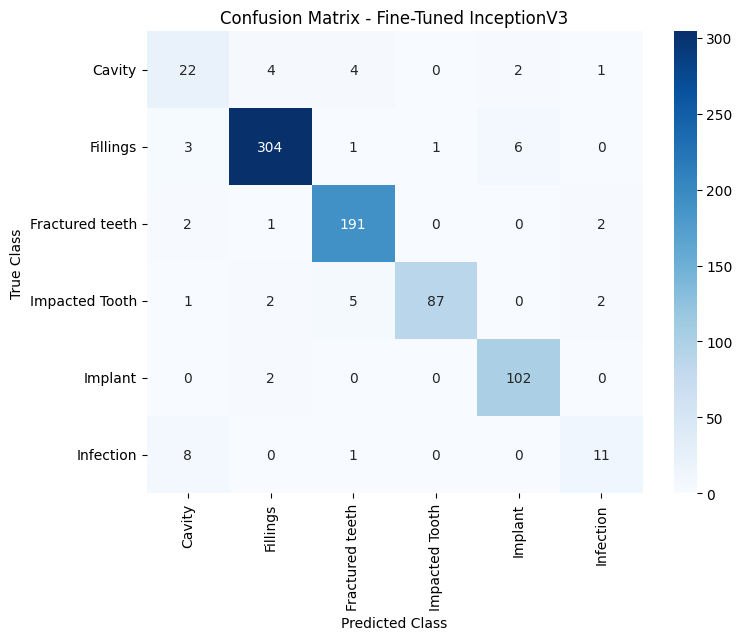

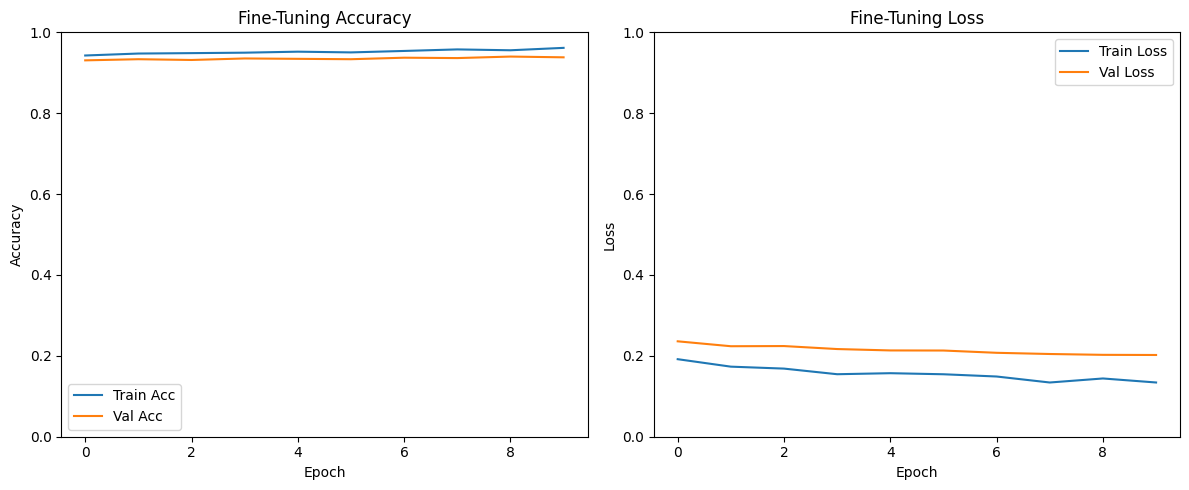

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_image
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

# Checkpoint callback to save model after each epoch
checkpoint_path = '/content/drive/MyDrive/dental_finetune_checkpoint.h5'
checkpoint_cb = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=False,  # Saves every epoch
    save_weights_only=False,
    verbose=1
)

# Add checkpoint to callbacks list
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1),
    checkpoint_cb  # <-- added
]

model_path = '/content/drive/MyDrive/dental_inceptionv3_model (1).h5'


# Parameters
IMG_HEIGHT, IMG_WIDTH = 299, 299
BATCH_SIZE = 32
FINE_TUNE_EPOCHS = 10

# Paths
base_dir = '/content/drive/MyDrive/croppedfolder/my_folder'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir  = os.path.join(base_dir, 'test')

# Data Generators
train_datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    preprocessing_function=preprocess_image
)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

# Load previously saved model (initial trained model)
model = load_model(model_path)

# Access the base InceptionV3 model from the loaded model
base_model = None
for layer in model.layers:
    if hasattr(layer, 'name') and 'inception' in layer.name.lower():
        base_model = layer
        break

if base_model is None:
    base_model = model.layers[0]  # Assuming InceptionV3 is the first layer

# Unfreeze top layers of the base model for fine-tuning
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Recompile with a low learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks with modified patience
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),  # Patience increased to 10
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)  # Adjust learning rate when no improvement
]

# Fine-tune training
history_finetune = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=FINE_TUNE_EPOCHS,
    callbacks=callbacks
)

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy after Fine-Tuning:", test_acc)

# Predictions and Metrics
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix - Fine-Tuned InceptionV3')
plt.show()

# Accuracy & Loss Graph
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_finetune.history['accuracy'], label='Train Acc')
plt.plot(history_finetune.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Fine-Tuning Accuracy')
plt.ylim([0, 1])
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_finetune.history['loss'], label='Train Loss')
plt.plot(history_finetune.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Fine-Tuning Loss')
plt.ylim([0, 1])
plt.legend()

plt.tight_layout()
plt.show()

# Save the fine-tuned model
model.save('dental_inceptionv3_finetuned.h5')

# Optional: Download
from google.colab import files
files.download('dental_inceptionv3_finetuned.h5')
